# Face Generation with Convolutional VAE

This notebook implements a convolutional variational autoencoder (VAE) trained on the CelebA face dataset using PyTorch.

It uses convolutional layers to encode and decode 64x64 face images, and demonstrates generation by sampling from the latent space.

In [ ]:
!pip install torch torchvision matplotlib

## 1. Import Required Libraries

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import os


## 2. Load CelebA Dataset

In [7]:
transform = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Resize(64),
    transforms.ToTensor()
])

# Download CelebA dataset (you must accept the license the first time)
celeba = torchvision.datasets.CelebA(root="./data", split="train", download=True, transform=transform)
dataloader = DataLoader(celeba, batch_size=128, shuffle=True)


## 3. Define the Convolutional VAE

### VAE Architecture Explained
- **Encoder**: uses 4 convolutional layers to compress the image into a latent vector.
- **Latent Space**: the model learns a distribution (mean and variance) over latent variables.
- **Reparameterization**: samples from this distribution to make training differentiable.
- **Decoder**: mirrors the encoder with transposed convolutions to reconstruct the image.

In [8]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # [B, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # [B, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # [B, 128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # [B, 256, 4, 4]
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # [B, 128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # [B, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # [B, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # [B, 3, 64, 64]
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z).view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


## 4. Define ELBO Loss

In [9]:
def elbo_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # MSE for real-valued images
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld


## 5. Train the VAE
This section trains the convolutional variational autoencoder (VAE) on the CelebA dataset using ELBO loss. After training, we will sample from the latent space to generate new face images.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvVAE(latent_dim=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5  # Adjust for better quality
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for x, _ in dataloader:
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        loss = elbo_loss(recon_x, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader):.2f}")


Epoch 1, Loss: 29744.51
Epoch 2, Loss: 21248.06
Epoch 3, Loss: 20511.19
Epoch 4, Loss: 20139.32
Epoch 5, Loss: 19904.67


## 6. Generate New Faces
In this section, we sample random latent vectors from a standard normal distribution and pass them through the decoder to generate new face images.

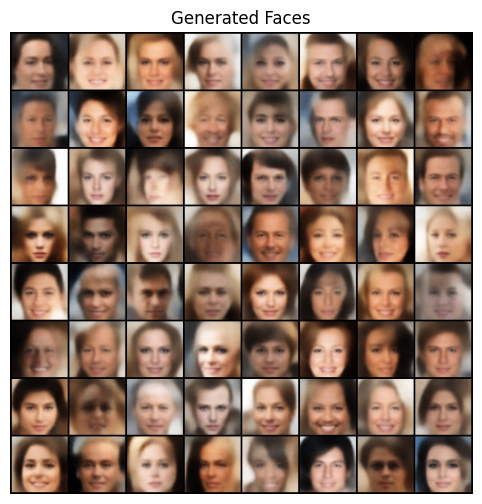

In [11]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Function to visualize generated images
def show_generated_images(samples, nrow=8):
    grid = make_grid(samples, nrow=nrow)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("Generated Faces")
    plt.show()

# Sample z ~ N(0, I) and generate faces
model.eval()
with torch.no_grad():
    z = torch.randn(64, model.latent_dim).to(device)
    generated = model.decode(z)

# Display
show_generated_images(generated)


## 7. Reconstruction Comparison
This section compares original images with their reconstructions to show how well the VAE preserves features.

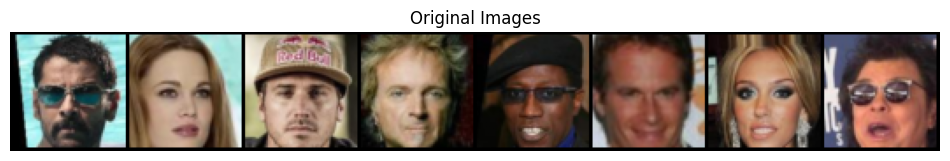

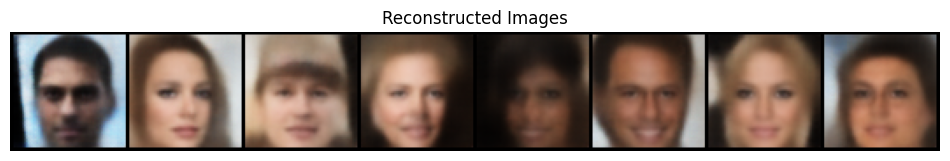

In [12]:
model.eval()
with torch.no_grad():
    # Take a small batch
    x, _ = next(iter(dataloader))
    x = x.to(device)
    recon_x, _, _ = model(x)

    # Convert to CPU and reshape for plotting
    x = x[:8].cpu()
    recon_x = recon_x[:8].cpu()

    from torchvision.utils import make_grid

    def show_grid(images, title):
        grid = make_grid(images, nrow=8)
        plt.figure(figsize=(12, 3))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(title)
        plt.axis('off')
        plt.show()

    show_grid(x, "Original Images")
    show_grid(recon_x, "Reconstructed Images")
